In [ ]:
import re
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from yellowbrick.text.freqdist import FreqDistVisualizer 

%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [2]:
# dataset is taken from Kaggle website
df_tweet = pd.read_csv('./dataset/train.csv')

# Note: this df does not have the target column
df_test = pd.read_csv('./dataset/test.csv')

In [3]:
print('There are {} rows and {} columns in the training dataset'.format(df_tweet.shape[0],df_tweet.shape[1]))
print('There are {} rows and {} columns in the testing dataset'.format(df_test.shape[0],df_test.shape[1]))

There are 7613 rows and 5 columns in the training dataset
There are 3263 rows and 4 columns in the testing dataset


In [4]:
# train data
df_tweet.tail(10)

,id,keyword,location,text,target
7603,10862,NaN,NaN,Officials say a quarantine is in place at an Alabama home over a possible Ebola case after developing symptoms... http://t.co/rqKK15uhEY,1
7604,10863,NaN,NaN,#WorldNews Fallen powerlines on G:link tram: UPDATE: FIRE crews have evacuated up to 30 passengers who were tr... http://t.co/EYSVvzA7Qm,1
7605,10864,NaN,NaN,on the flip side I'm at Walmart and there is a bomb and everyone had to evacuate so stay tuned if I blow up or not,1
7606,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site mosque - Reuters via World - Google News - Wall ... http://t.co/nF4IculOje,1
7607,10867,NaN,NaN,#stormchase Violent Record Breaking EF-5 El Reno Oklahoma Tornado Nearly Runs Over ... - http://t.co/3SICroAaNz http://t.co/I27Oa0HISp,1
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d,1


In [5]:
# test data . Note: it does not have target column and just can be used for testing
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
print('missing values of the keyword column: {}/{} ({}%)'.
      format(df_tweet.keyword.isna().sum(),len(df_tweet),
             round((df_tweet.keyword.isna().sum() / len(df_tweet)) * 100,2)))

print('missing values of the location column: {}/{} ({}%)'.
      format(df_tweet.location.isna().sum(), len(df_tweet),
             round((df_tweet.location.isna().sum() / len(df_tweet)) * 100,2)))

missing values of the keyword column: 61/7613 (0.8%)
missing values of the location column: 2533/7613 (33.27%)


In [7]:
df_tweet.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

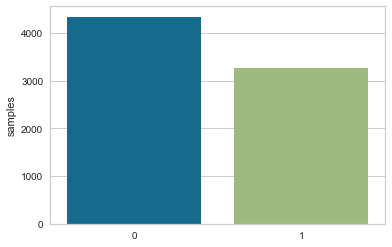

In [8]:
# the number of classes are almost balanced. So, we do not need to balance them.
# However, there are more tweets with class 0 (No disaster) than class 1 (disaster tweets)

target_counts = df_tweet.target.value_counts()
sns.barplot(target_counts.index,target_counts)
plt.gca().set_ylabel('samples')
plt.show();

### Number of characters in tweets

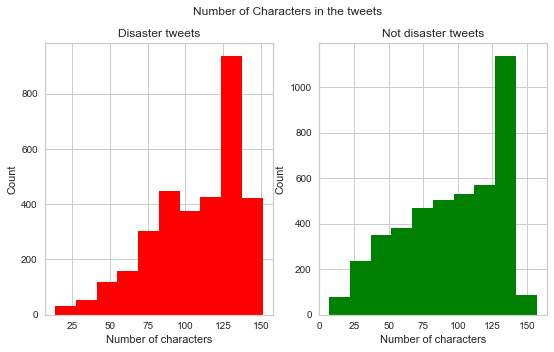

In [9]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(9,5))

tweet_disaster_len=df_tweet[df_tweet.target == 1]['text'].str.len()
ax1.hist(tweet_disaster_len,color='red')
ax1.set_title('Disaster tweets')
ax1.set_xlabel('Number of characters')
ax1.set_ylabel('Count')

tweet_not_disaster_len=df_tweet[df_tweet.target == 0]['text'].str.len()
ax2.hist(tweet_not_disaster_len,color='green')
ax2.set_title('Not disaster tweets')
ax2.set_xlabel('Number of characters')
ax2.set_ylabel('Count')

fig.suptitle('Number of Characters in the tweets')
plt.show();

### Number of words in a tweet

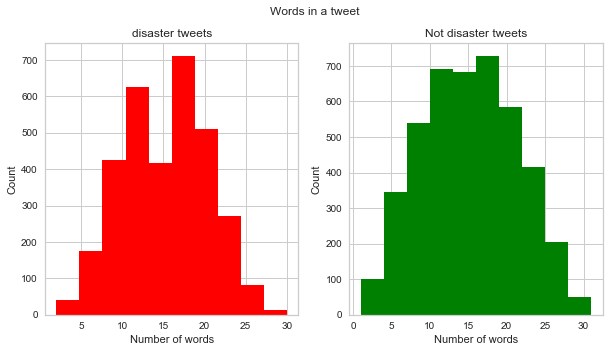

In [10]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_disaster_len=df_tweet[df_tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_disaster_len,color='red')
ax1.set_title('disaster tweets')
ax1.set_xlabel('Number of words')
ax1.set_ylabel('Count')

tweet_not_disaster_len=df_tweet[df_tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_not_disaster_len,color='green')
ax2.set_title('Not disaster tweets')
ax2.set_xlabel('Number of words')
ax2.set_ylabel('Count')

fig.suptitle('Words in a tweet')
plt.show();

we are going to drop the columns which have missing values as well as ID. 
ID does not add any value to the model that we are about to create.

In [11]:
df_tweet.drop(['id','location', 'keyword'], axis=1, inplace=True)

In [12]:
df_tweet.tail(10)

,text,target
7603,Officials say a quarantine is in place at an Alabama home over a possible Ebola case after developing symptoms... http://t.co/rqKK15uhEY,1
7604,#WorldNews Fallen powerlines on G:link tram: UPDATE: FIRE crews have evacuated up to 30 passengers who were tr... http://t.co/EYSVvzA7Qm,1
7605,on the flip side I'm at Walmart and there is a bomb and everyone had to evacuate so stay tuned if I blow up or not,1
7606,Suicide bomber kills 15 in Saudi security site mosque - Reuters via World - Google News - Wall ... http://t.co/nF4IculOje,1
7607,#stormchase Violent Record Breaking EF-5 El Reno Oklahoma Tornado Nearly Runs Over ... - http://t.co/3SICroAaNz http://t.co/I27Oa0HISp,1
7608,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1
7609,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1
7611,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1
7612,The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d,1


### Remove URLs 

In [13]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

df_tweet['text'] = df_tweet['text'].apply(lambda x : remove_URL(x))

In [14]:
df_tweet.tail(10)

,text,target
7603,Officials say a quarantine is in place at an Alabama home over a possible Ebola case after developing symptoms...,1
7604,#WorldNews Fallen powerlines on G:link tram: UPDATE: FIRE crews have evacuated up to 30 passengers who were tr...,1
7605,on the flip side I'm at Walmart and there is a bomb and everyone had to evacuate so stay tuned if I blow up or not,1
7606,Suicide bomber kills 15 in Saudi security site mosque - Reuters via World - Google News - Wall ...,1
7607,#stormchase Violent Record Breaking EF-5 El Reno Oklahoma Tornado Nearly Runs Over ... -,1
7608,Two giant cranes holding a bridge collapse into nearby homes,1
7609,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii.,1
7611,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1
7612,The Latest: More Homes Razed by Northern California Wildfire - ABC News,1


In [15]:
documents = list()

#wnl = WordNetLemmatizer()
ps = PorterStemmer()

for i in range(0, len(df_tweet)):
    
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(df_tweet.loc[i,'text']))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to lowercase
    document = document.lower()
    
    # lemmatization and stemmer
    # In lemmatization, we can convert the word into the root form of the word. 
    # for exampel, "houses" is converted into "house".
    document = document.split()
    document = [ps.stem(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

In [16]:
len(documents)

7613

In [17]:
df_tweet[40:50]

,text,target
40,Check these out: #nsfw,0
41,on the outside you're ablaze and alive\nbut you're dead inside,0
42,Had an awesome time visiting the CFC head office the ancop site and ablaze. Thanks to Tita Vida for taking care of us ??,0
43,SOOOO PUMPED FOR ABLAZE ???? @southridgelife,0
44,I wanted to set Chicago ablaze with my preaching... But not my hotel!,0
45,I gained 3 followers in the last week. You? Know your stats and grow with,0
46,How the West was burned: Thousands of wildfires ablaze in California alone,1
47,Building the perfect tracklist to life leave the streets ablaze,0
48,Check these out: #nsfw,0
49,First night with retainers in. It's quite weird. Better get used to it; I have to wear them every single night for the next year at least.,0


In [18]:
# print 10 rows
documents[40:50]

['check these out nsfw',
 'on the outsid you re ablaz and aliv but you re dead insid',
 'had an awesom time visit the cfc head offic the ancop site and ablaz thank to tita vida for take care of us',
 'soooo pump for ablaz southridgelif',
 'i want to set chicago ablaz with my preach but not my hotel',
 'i gain 3 follow in the last week you know your stat and grow with',
 'how the west wa burn thousand of wildfir ablaz in california alon',
 'build the perfect tracklist to life leav the street ablaz',
 'check these out nsfw',
 'first night with retain in it quit weird better get use to it have to wear them everi singl night for the next year at least']

## Converting Text to Numbers

Machines cannot understand the raw text. Machines can only understand numbers. 
Statistical techniques including machine learning can only deal with numbers. 
Therefore, we need to convert our text into numbers.

<ul>   
   <li><b>max_features:</b> Build a vocabulary that only consider the top max_features ordered by term frequency across the corpus</li>
    <li><b>max_df:</b> When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold.</li>
    </ul>

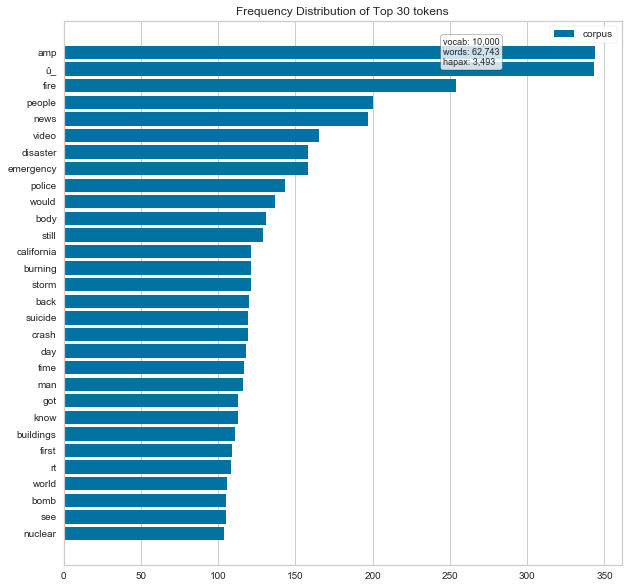

In [19]:
# Find the document term frequency matrix
stopwords = nltk.corpus.stopwords.words('english')

# add some more stop words
newStopWords = ['http','https', 'co', 'via', 'us','like','one','get','new']
stopwords.extend(newStopWords)

vectorizer = CountVectorizer(max_features=10000,
                             analyzer='word',
                             max_df=.6,
                             stop_words=stopwords)

X = vectorizer.fit_transform(df_tweet['text'])

# Get all features (tokens)
features = vectorizer.get_feature_names()

# we can use yellowbrick package for visualization of top 30 tokens
fig, ax = plt.subplots(figsize=(10, 10))
visualizer = FreqDistVisualizer(features=features, n=30, orient='h')
visualizer.fit(X)
visualizer.poof()

In [20]:
X = vectorizer.fit_transform(documents).toarray()

tfidfconverter = TfidfTransformer()

X = tfidfconverter.fit_transform(X).toarray()
y = df_tweet['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=0)

### Creating the model

In [ ]:
rfc = RandomForestClassifier(n_estimators=800, 
                             random_state=42, 
                             max_features='auto')

rfc.fit(X_train, y_train)

# predict for testing data
y_pred_test = rfc.predict(X_test)

# predict for training data
y_pred_train = rfc.predict(X_train)

In [ ]:
# test
print(accuracy_score(y_test, y_pred_test))
print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))

In [ ]:
# train
print(accuracy_score(y_train, y_pred_train))
print(confusion_matrix(y_train,y_pred_train))
print(classification_report(y_train,y_pred_train))

### Save the Model

In [ ]:
#The wb indicates that the file is opened for writing in binary mode
with open('text_classifier', 'wb') as picklefile:
    pickle.dump(rfc,picklefile)

### Load the Model

In [ ]:
#The rb indicates that the file is opened for reading in binary mode
with open('text_classifier', 'rb') as training_model:
    model = pickle.load(training_model)

### Make prediction based on the Loaded model

In [ ]:
y_pred_test_2 = model.predict(X_test)

print(confusion_matrix(y_test, y_pred_test_2))
print(classification_report(y_test, y_pred_test_2))
print(accuracy_score(y_test, y_pred_test_2)) 